# Fuzzy Clustering with Anomalous Patterns

> a) Study the fuzzy c-means (FCM) program in the software package of your choice1.
Apply the program to your dataset at the same hyperparameter c with random seeds. Do this for several different values c= c_min, ..., c_max. Plot the FCM clustering criterion (FCM cost function) in function of c. Analyse the graphic and comment if any number of clusters better fits your data than the others.
Hint: If, at a given c, the fuzzy c-means converges to the same result at any initialization, then it is likely that parameter c is correct.

As we are working with Python we chose to study and work with `skfuzzy 0.2` which offers the FCM algorithm as `skfuzzy.cmeans(data, c, m, error, maxiter, init=None, seed=None)` implemented according to Ross et al. [1]

[1] Ross, Timothy J. Fuzzy Logic With Engineering Applications, 3rd ed.
           Wiley. 2010. ISBN 978-0-470-74376-8 pp 352-353, eq 10.28 - 10.35.

In [1]:
import skfuzzy as fuzz
import pandas as pd

data = pd.read_csv('./communities_processed.csv')

data = data.drop('ViolentCrimesPerPop', axis = 1)
data

,population,householdsize,agePct12t29,agePct65up,medFamInc,PctPopUnderPov,MedRentPctHousInc,TotalPctDiv,PctLargHouseFam,pctUrban,PctHousOccup
0,11980,3.10,21.44,11.33,79584,1.96,316,4.47,4.81,100.00,98.37
1,23123,2.82,21.30,17.18,55323,3.98,205,5.42,4.25,100.00,97.15
2,29344,2.43,25.88,10.28,42112,4.75,150,12.55,2.97,100.00,95.68
3,16656,2.40,25.20,17.57,26501,17.23,114,12.91,3.93,0.00,91.19
4,11245,2.76,40.53,12.65,24018,29.99,160,9.73,5.23,0.00,92.45
...,...,...,...,...,...,...,...,...,...,...,...
2210,56216,3.07,30.16,8.08,27388,25.06,157,13.34,13.49,100.00,96.40
2211,12251,2.68,31.23,12.57,25000,20.79,121,13.77,5.03,100.00,89.72
2212,32824,2.46,20.96,20.73,34973,7.56,204,11.23,5.10,100.00,93.30
2213,13547,2.89,30.01,10.42,22103,30.32,182,12.48,9.83,0.00,85.39


`skfuzzy.cmeans()` provides the following interface:

```
Parameters
    ----------
    data : 2d array, size (S, N)
        Data to be clustered.  N is the number of data sets; S is the number
        of features within each sample vector.
    c : int
        Desired number of clusters or classes.
    m : float
        Array exponentiation applied to the membership function u_old at each
        iteration, where U_new = u_old ** m.
    error : float
        Stopping criterion; stop early if the norm of (u[p] - u[p-1]) < error.
    maxiter : int
        Maximum number of iterations allowed.
    init : 2d array, size (S, N)
        Initial fuzzy c-partitioned matrix. If none provided, algorithm is
        randomly initialized.
    seed : int
        If provided, sets random seed of init. No effect if init is
        provided. Mainly for debug/testing purposes.

    Returns
    -------
    cntr : 2d array, size (S, c)
        Cluster centers.  Data for each center along each feature provided
        for every cluster (of the `c` requested clusters).
    u : 2d array, (S, N)
        Final fuzzy c-partitioned matrix.
    u0 : 2d array, (S, N)
        Initial guess at fuzzy c-partitioned matrix (either provided init or
        random guess used if init was not provided).
    d : 2d array, (S, N)
        Final Euclidian distance matrix.
    jm : 1d array, length P
        Objective function history.
    p : int
        Number of iterations run.
    fpc : float
        Final fuzzy partition coefficient.

```

We evaluated the hyperparameter `c` defining the number of desired clusters on a range from `c_min` = 2, 3, 4 ... to `c_max` = 22. The `c_max` parameter stems from the fact that we have 2215 datapoints in total and assume that meaningful clusters for our dataset of communitites should at least have size 10 to keep them interpretable.

According to Ross et al. [1] p. 354 and our classes so far research has not concluded on a theoretical optimum for parameter `m`. However, setting `m` to a value between 1.25 - 2, and especially setting `m` to 2 seems to provide good results. 
For our project we chose to set `m` to 2.

The `error` parameter sets the threshold for the stopping criterion by convergence. If the difference between the clustering criterion between to iterations sinks below the specified threshold, calculations are stopped. We followed the example from Ross et al. and set the error to `0.01`.

The `maxiter` parameter defines the second stopping criterion by number of iterations. If no convergence of the error could be reached, the calculation stopps after the set maximum number of iterations. As we preferred to reach a solution with a convergence stopping criterion we set the `maxiter` parameter to the high value of 100. 
#TODO: Track how many iterations it actually took.

As the implementation already starts with random seeds if no `init` matrix is specified we did not have to specifiy random seeds on our own.

As first tests with different `c` parameters set to 2, 4, 10 and 20, showed that for all `c` the variation within the objective function convergence value was quite big, we decided to run the simulation 1000 times for each `c` to us the law of big numbers to obtain better results.

In [ ]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import math

import itertools

def plot_distributions(df, n_plots, n_cols):
    n_rows = math.ceil(n_plots / n_cols)
    subplot_indices = list(itertools.product(range(1, n_rows + 1), range(1, n_cols + 1)))

    fig = make_subplots(rows=n_rows, cols=n_cols, start_cell="top-left")

    for index, feature in zip(range(0, n_plots), df):
        fig.add_trace(go.Histogram(x = df[feature],  name=feature), row = subplot_indices[index][0], col= subplot_indices[index][1])
        
    fig.show()

In [2]:
from collections import defaultdict

def calc_fuzzy_c_means(data, c_params, initial_prototypes=None):
    objective_function_data = defaultdict(list)
    
    m = 2
    error = 0.01
    maxiter = 100
    runs = 1000

    objective_function_index = 4
    final_fuzzy_partition_index = 0

    for c in c_params:
        for i in range(1, runs + 1):
            c_means_result = fuzz.cmeans(data, c, m, error, maxiter, init=initial_prototypes)
            # append the last objective function value / the value where the function converged
            objective_function_data[c].append(c_means_result[final_fuzzy_partition_index][-1])
    return pd.DataFrame(objective_function_data)

def calc_fuzzy_c_means_anom(data, c_param, initial_prototypes=None):
    results = []
    m = 2
    error = 0.01
    maxiter = 100
    runs = 1000
    
    return fuzz.cmeans(data, c_param, m, error, maxiter, init=initial_prototypes)   

In [ ]:
c_params = [2, 3, 4, 5, 6, 7, 8, 9, 10, 12, 15, 20]
objective_function_data_unnormalized = calc_fuzzy_c_means(data, c_params, None)

In [ ]:
print(objective_function_data_unnormalized)
print(objective_function_data_unnormalized.std())

In [ ]:
print(objective_function_data_unnormalized.min())
print(objective_function_data_unnormalized.max())

In [ ]:
plot_distributions(objective_function_data_unnormalized, len(c_params), 3)

Apparently there is a huge variation for the convergence value of the objective value for all investigated `c` values if the data is not normalized.

In [5]:
# range normalization because we cannot make normal distribution assumption
data_norm = (data - data.min()) / (data.max() - data.min())

In [ ]:
objective_function_data_normalized = calc_fuzzy_c_means(data_norm, c_params)

In [ ]:
plot_distributions(objective_function_data_normalized, len(c_params), 3)

But while normalized data performed much better (as is logical for c fuzzy means because of the otherwise differing variations and therefore differing impacts), still no real convergences to identical values observable anywhere. Perhaps best for `c` == 3 where we only have a few weird outliers close to 0. 

In [ ]:
objective_function_data_normalized.mean()

In [ ]:
import plotly.express as px
fig = px.scatter(x = c_params, y = objective_function_data_normalized.mean())
fig.show()

In [ ]:
fig = px.scatter(x = c_params, y = objective_function_data_normalized.std())
fig.show()

`HK=(WK/WK+1 −1)(N−K−1)` should we evaluate Hartigans index?

- Visualize on the Principial Component Plane

> b) Study the (Iterative) Anomalous Pattern (IAP) clustering algorithm. Test the implementation with the benchmark data sets provided to you.

IAP clustering algorithm is an approach used to deal with the main challenges of the K-Means algorithm: specifiying the number of clusters and starting centroids a priori.

In [3]:
import pandas as pd
import numpy as np
from anomalous_adapted import anomPattern #code provided by professor


town_dataframe = pd.read_fwf('./tons.dat', names = ['POP_RES', 'PSchools', 'Doctors', 'Hospitals', 'Banks', 'Superstores', 'Petrol', 'DIY', 'Swimming', 'PostOffice', 'CABs', 'FarmMarket']) 
res = anomPattern(normalization=0,threshold=5,dataframe=town_dataframe)

/home/moritz/Uni/Portugal/PAD/pad_python/analyses/anomalous_adapted.py:180: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ancl = np.asarray(ancl)
/home/moritz/Uni/Portugal/PAD/pad_python/analyses/anomalous_adapted.py:180: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ancl = np.asarray(ancl)


> c) Take the Anomalous Clustering as the initialization algorithm to the fuzzy c-means and apply the Anomalous Patterns_FCM to your data set. Discuss the option taken for setting its stop condition. Present and visualize the found fuzzy partitions of AP-FCM taking advantage of the PCA visualization (check PCA tutorial).

/home/moritz/Uni/Portugal/PAD/pad_python/analyses/anomalous_adapted.py:180: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ancl = np.asarray(ancl)


Amount of Clusters:  3
(3, 11)
             0         1
0    -0.365572 -0.446986
1    -0.329557 -0.273646
2    -0.303317  0.021425
3     0.727893  0.082333
4     0.753491  0.128830
...        ...       ...
2210 -0.250050  0.335861
2211 -0.245246  0.311766
2212 -0.294728  0.026551
2213  0.753953  0.226693
2214 -0.250579  0.363086

[2215 rows x 2 columns]
          0         1
0 -0.498416  0.746541
1  1.122771 -0.053813
2 -0.624355 -0.692728


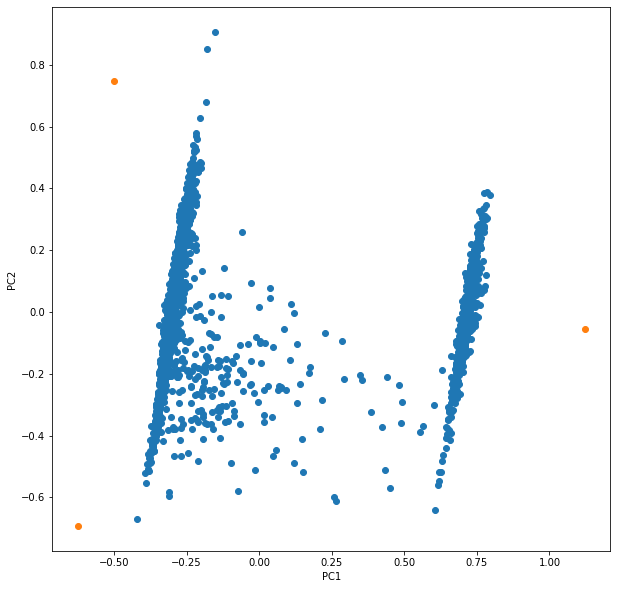

In [24]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns

#apply anomalous pattern algorithm to find start configuration
anom_res = anomPattern(normalization=0, threshold=50, dataframe=data_norm)
print('Amount of Clusters: ', anom_res[0])
#apply fuzzy-c-means
result = calc_fuzzy_c_means_anom(data_norm, anom_res[0], anom_res[1])
cluster_centroids = result[1] #should be zero, but dimensions of result[0] are 4x2215
print(cluster_centroids.shape)

#perform PCA on dataset
principal=PCA(n_components=2)
principal.fit(data_norm)
x1 = principal.transform(data_norm)
principalDf = pd.DataFrame(data = x1)
print(principalDf)

#perform PCA on cluster centers
principal = PCA(n_components=2)
principal.fit(cluster_centroids)
x2 = principal.transform(cluster_centroids)
principalCc = pd.DataFrame(data = x2)
print(principalCc)

fig = plt.figure(figsize=(10,10))
# choose projection 3d for creating a 3d graph
axis = fig.add_subplot(111)
# x[:,0]is pc1,x[:,1] is pc2 while x[:,2] is pc3
axis.scatter(x1[:, 0], x1[:, 1], cmap='hot')
axis.scatter(x2[:, 0], x2[:, 1], cmap='hot')
axis.set_xlabel("PC1", fontsize=10)
axis.set_ylabel("PC2", fontsize=10)


plt.show()





> d) Discuss the results obtained by Anomalous Patterns FCM for your data case respecting the following: (i) location of the initial prototypes; (ii) number of clusters.

> e) Apply, at least, two validation indices, like the Adjust Rand Index (ARI) and Xie-Beni, to access the quality of the fuzzy c-partitions obtained in a). Compare these results with the one of Anomalous Patterns FCM getting in c).

> f) Make interpretation of the found clusters (after defuzzification) for your data, as discussed in the classes.